In [ ]:
from scipy.signal import spectrogram
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

# Chargement des fichiers de référence
Fs, reference_hyper = wavfile.read('alarms/hyper.wav')
_ , reference_hypo = wavfile.read('alarms/hypo.wav')

def convert_to_mono(s):
    if len(s.shape) == 2:  
        s = s.mean(axis=1) 
    return s

def filter_signal(s, Wn1, Wn2, type, Fs):
    Wn = [Wn1 / (Fs / 2), Wn2 / (Fs / 2)] 
    b, a = signal.butter(1, Wn, type) 
    s = signal.filtfilt(b, a, s)
    return s

def apply_filter(Fs, s):
    s = filter_signal(s, 1311, 1723, 'band', Fs)
    s = filter_signal(s, 1313, 1409, 'stop', Fs)
    s = filter_signal(s, 1411, 1499, 'stop', Fs)
    s = filter_signal(s, 1501, 1618, 'stop', Fs)
    s = filter_signal(s, 1620, 1721, 'stop', Fs)
    return s

def read_file(file):
    Fs, s = wavfile.read(file)
    s = convert_to_mono(s)
    return Fs, s

def filter_spectrogram(frequencies, spectrogram, freq_min, freq_max):
    """
    Filtre un spectrogramme pour ne conserver que les fréquences dans une plage donnée.
    """
    indices = (frequencies >= freq_min) & (frequencies <= freq_max)
    frequencies_filtered = frequencies[indices]
    spectrogram_filtered = spectrogram[indices, :]
    return frequencies_filtered, spectrogram_filtered

def display_spectrogram(Fs, s, freq_min=1000, freq_max=2000):
    """
    Affiche le spectrogramme d'un signal, filtré pour ne conserver que certaines fréquences.
    """
    f, t, Sxx = signal.spectrogram(s, Fs, window='hamming', nperseg=1024, noverlap=512)
    f_filtered, Sxx_filtered = filter_spectrogram(f, Sxx, freq_min, freq_max)
    
    # Affichage du spectrogramme filtré
    plt.pcolormesh(t, f_filtered, np.log10(Sxx_filtered + 1e-10))
    plt.ylabel('Fréquences (Hz)')
    plt.xlabel('Temps (s)')
    plt.title(f'Spectrogramme filtré ({freq_min}-{freq_max} Hz)')
    plt.colorbar(label='Amplitude (log10)')
    plt.show()

# Lecture et traitement du fichier d'entrée
Fs, s = read_file('alarms/hyper_chien.wav')
s = apply_filter(Fs, s)

# Affichage des spectrogrammes
display_spectrogram(Fs, s)


In [ ]:
from scipy.signal import spectrogram
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Fréquences cibles pour les sons hypo et hyper
TARGET_FREQUENCIES = [1312, 1410, 1500, 1619, 1722]

# --- Charger le fichier audio ---
def read_file(file):
    Fs, s = wavfile.read(file)
    if s.ndim > 1:
        s = s.mean(axis=1)  # Convertir en mono si nécessaire
    return Fs, s

# --- Calculer le spectrogramme ---
def compute_spectrogram(Fs, s):
    f, t, Sxx = spectrogram(s, Fs, window='hamming', nperseg=1024, noverlap=512)
    return f, t, Sxx

# --- Détection des fréquences cibles ---
def detect_frequencies(f, Sxx, target_frequencies, threshold=0.01):
    """
    Détecte si les fréquences cibles sont présentes dans le spectrogramme.
    """
    detected = []
    for target in target_frequencies:
        idx = np.abs(f - target).argmin()  # Trouver l'index de la fréquence cible
        if Sxx[idx, :].max() > threshold:  # Vérifier si l'amplitude dépasse un seuil
            detected.append(target)
    return detected

# --- Analyser l'ordre des fréquences détectées ---
def analyze_frequency_order(detected_frequencies):
    """
    Analyse si les fréquences détectées suivent un ordre croissant ou décroissant.
    """
    if len(detected_frequencies) == len(TARGET_FREQUENCIES):
        if detected_frequencies == sorted(TARGET_FREQUENCIES, reverse=True):
            return "hypo"
        elif set(detected_frequencies) == set(TARGET_FREQUENCIES):
            return "hyper"
    return "none"

# --- Afficher le spectrogramme ---
def plot_spectrogram(f, t, Sxx):
    plt.pcolormesh(t, f, np.log10(Sxx + 1e-10), shading='gouraud')
    plt.ylabel('Fréquences (Hz)')
    plt.xlabel('Temps (s)')
    plt.colorbar(label='Amplitude (log10)')
    plt.title("Spectrogramme")
    plt.show()

# --- Script principal ---
def main(input_file):
    # Charger le fichier audio
    Fs, s = read_file(input_file)

    # Calculer le spectrogramme
    f, t, Sxx = compute_spectrogram(Fs, s)

    # Détection des fréquences cibles
    detected_frequencies = detect_frequencies(f, Sxx, TARGET_FREQUENCIES)

    # Analyser l'ordre des fréquences détectées
    result = analyze_frequency_order(detected_frequencies)

    # Afficher le spectrogramme
    plot_spectrogram(f, t, Sxx)

    # Afficher le résultat de la détection
    if result == "hyper":
        print("Le signal est de type HYPER (fréquences décroissantes).")
    elif result == "hypo":
        print("Le signal est de type HYPO (fréquences détectées dans un ordre quelconque).")
    else:
        print("Aucun signal HYPER ou HYPO détecté.")

# --- Exécution ---
if __name__ == "__main__":
    input_file = 'alarms/hypo_fanfare.wav'  # Remplacez par votre fichier .wav
    main(input_file)


In [ ]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

def load_audio(file_path):
    # Charger le fichier .wav
    sample_rate, audio = wavfile.read(file_path)
    
    # Si stéréo, convertir en mono
    if len(audio.shape) > 1:
        audio = audio.mean(axis=1).astype(np.int16)
    return audio, sample_rate

def convert_to_binary_matrix(audio, num_bits=16):
    # Normaliser les échantillons si nécessaire
    if audio.dtype == np.float32 or audio.dtype == np.float64:
        audio = (audio * (2**(num_bits - 1))).astype(np.int16)
    
    # Convertir chaque échantillon en binaire
    binary_matrix = np.array([list(f"{sample:0{num_bits}b}") for sample in audio], dtype=int)
    return binary_matrix

def display_binary_matrix(binary_matrix):
    # Afficher la matrice sous forme d'image
    plt.figure(figsize=(10, 5))
    plt.imshow(binary_matrix, cmap='Greys', aspect='auto')
    plt.xlabel("Bits")
    plt.ylabel("Échantillons")
    plt.title("Matrice binaire du fichier audio")
    plt.colorbar(label="Valeurs binaires (0 ou 1)")
    plt.show()

# --- Script principal ---
if __name__ == "__main__":
    file_path = "alarms/hyper_chien.wav"  # Remplacez par votre fichier .wav
    audio, sample_rate = load_audio(file_path)
    binary_matrix = convert_to_binary_matrix(audio)
    display_binary_matrix(binary_matrix)


In [ ]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

def load_audio(file_path):
    # Charger le fichier .wav
    sample_rate, audio = wavfile.read(file_path)
    
    # Si stéréo, convertir en mono
    if len(audio.shape) > 1:
        audio = audio.mean(axis=1).astype(np.int16)
    return audio, sample_rate

def normalize_audio(audio):
    # Normaliser les échantillons entre 0 et 1
    # Convertir les échantillons int16 dans une plage [0, 1] (les échantillons sont entre -32768 et 32767)
    normalized_audio = (audio - np.min(audio)) / (np.max(audio) - np.min(audio))
    return normalized_audio

def convert_to_binary_matrix(normalized_audio, num_bits=16):
    # Convertir chaque échantillon normalisé en binaire
    binary_matrix = np.zeros((len(normalized_audio), num_bits), dtype=int)
    for i, sample in enumerate(normalized_audio):
        # Convertir la valeur normalisée en une valeur binaire de 16 bits
        # Nous avons besoin de multiplier par 2^16 pour ramener à l'échelle entière
        sample_scaled = int(np.clip(sample * (2**num_bits - 1), 0, 2**num_bits - 1))
        
        # Convertir le nombre entier en binaire
        binary_str = f"{sample_scaled:0{num_bits}b}"
        # Remplir la ligne de la matrice avec les bits
        binary_matrix[i] = [int(bit) for bit in binary_str]
    
    return binary_matrix

def display_binary_matrix(binary_matrix):
    # Afficher la matrice sous forme d'image
    plt.figure(figsize=(10, 5))
    plt.imshow(binary_matrix, cmap='Greys', aspect='auto')
    plt.xlabel("Bits")
    plt.ylabel("Échantillons")
    plt.title("Matrice binaire du fichier audio")
    plt.colorbar(label="Valeurs binaires (0 ou 1)")
    plt.show()

# --- Script principal ---
if __name__ == "__main__":
    file_path = "alarms/hyper.wav"  # Remplacez par votre fichier .wav
    audio, sample_rate = load_audio(file_path)
    
    # Normaliser les données audio entre 0 et 1
    normalized_audio = normalize_audio(audio)
    
    # Convertir les données normalisées en matrice binaire
    binary_matrix = convert_to_binary_matrix(normalized_audio)
    
    # Afficher la matrice binaire
    display_binary_matrix(binary_matrix)


In [ ]:
from pydub import AudioSegment
import numpy as np

# Charger le fichier audio
audio = AudioSegment.from_wav('alarms/hyper_chien.wav')

# Convertir en mono (si stéréo, pour simplifier la conversion)
audio = audio.set_channels(1)

# Convertir en tableau numpy
samples = np.array(audio.get_array_of_samples())

# Afficher les échantillons sous forme binaire
binary_samples = ['{0:016b}'.format(sample) for sample in samples[:10]]  # Affiche les 10 premiers
print(binary_samples)


In [ ]:
import wave
import numpy as np

# Ouvrir le fichier WAV
fichier_audio = wave.open('alarms/hyper_chien.wav', 'rb')

# Lire les paramètres du fichier audio (comme la fréquence d'échantillonnage, le nombre de canaux, etc.)
params = fichier_audio.getparams()
print(f"Paramètres du fichier audio : {params}")

# Lire les données brutes
data = fichier_audio.readframes(params.nframes)

# Convertir les octets en un tableau numpy (ici en format d'échantillons 16 bits)
audio_data = np.frombuffer(data, dtype=np.int16)

# Si l'audio est stéréo, chaque échantillon a 2 valeurs (un pour chaque canal)
if params.nchannels == 2:
    audio_data = audio_data[::2]  # Prendre seulement un canal (gauche ou droit)

# Afficher les premières valeurs audio sous forme binaire
print("Représentation binaire des 10 premiers échantillons :")
print(['{:016b}'.format(i) for i in audio_data[:10]])  # Chaque échantillon en binaire sur 16 bits


In [ ]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import butter, lfilter

# Fonction pour créer un filtre passe-bande de Butterworth
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs  # Fréquence de Nyquist
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Appliquer le filtre passe-bande
def apply_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return lfilter(b, a, data)

# Charger le fichier audio
file_path = "alarms/hyper.wav"
sample_rate, audio = wavfile.read(file_path)

# Vérifier si l'audio est stéréo (2 canaux)
if audio.ndim == 2 and audio.shape[1] == 2:  # Si c'est stéréo
    # Calculer la moyenne des deux canaux pour chaque échantillon (conversion en mono)
    audio = np.mean(audio, axis=1)  # Moyenne des colonnes (canaux gauche et droit)

# Appliquer un filtre passe-bande pour ne garder que les fréquences entre 1300 Hz et 1800 Hz
lowcut = 1300  # Fréquence de coupure basse (1300 Hz)
highcut = 1800  # Fréquence de coupure haute (1800 Hz)
filtered_audio = apply_bandpass_filter(audio, lowcut, highcut, sample_rate)

# Normalisation pour que les valeurs restent entre 0 et 1
min_val = np.min(filtered_audio)  # Trouver la valeur minimale
max_val = np.max(filtered_audio)  # Trouver la valeur maximale

# Ramener les valeurs entre 0 et 1
normalized_audio = (filtered_audio - min_val) / (max_val - min_val)

# Convertir en format binaire (en utilisant une résolution de 16 bits)
def audio_to_binary_matrix(audio, num_bits=16):
    # Convertir chaque échantillon en binaire
    # Note : On multiplie par (2**num_bits - 1) pour avoir une représentation entière entre 0 et (2**num_bits - 1)
    max_val_int = (2**num_bits - 1)
    audio_scaled = (audio * max_val_int).astype(int)  # Mettre dans la plage entière

    # Convertir chaque échantillon en binaire
    binary_matrix = np.array([list(format(sample, f"0{num_bits}b")) for sample in audio_scaled], dtype=int)
    return binary_matrix

# Convertir l'audio normalisé en matrice binaire
binary_matrix = audio_to_binary_matrix(normalized_audio)

# Affichage des résultats
print(f"Dimensions de la matrice binaire : {binary_matrix.shape}")
print("Les 10 premiers échantillons en binaire :")
print(binary_matrix[40000:40020])


In [ ]:
import librosa
import numpy as np

# Paramètres
sequence_to_detect = [1312, 1410, 1500, 1619, 1722]
tolerance = 5  # Tolérance en Hz pour considérer une fréquence comme correspondante

def find_sequence(audio_path, sequence, tolerance):
    # Charger le fichier audio
    y, sr = librosa.load(audio_path, sr=None)  # y: signal audio, sr: fréquence d'échantillonnage
    
    # Calcul de la STFT (Short-Time Fourier Transform)
    S = np.abs(librosa.stft(y))
    frequencies = librosa.fft_frequencies(sr=sr)
    
    # Identifier les fréquences dominantes dans chaque fenêtre
    dominant_frequencies = []
    for spectrum in S.T:
        idx = np.argmax(spectrum)  # Indice de la fréquence dominante
        dominant_frequencies.append(frequencies[idx])
    
    # Rechercher la séquence
    matched_indices = []
    for i, freq in enumerate(dominant_frequencies):
        if len(matched_indices) < len(sequence) and abs(freq - sequence[len(matched_indices)]) <= tolerance:
            matched_indices.append(i)
        elif len(matched_indices) == len(sequence):
            break
        else:
            matched_indices = []  # Réinitialiser si la séquence est interrompue
    
    if len(matched_indices) == len(sequence):
        print(f"Séquence détectée aux indices {matched_indices}")
    else:
        print("Séquence non trouvée")

# Exemple d'utilisation
audio_path = "alarms/hyper.wav"
find_sequence(audio_path, sequence_to_detect, tolerance)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read

# Charger un fichier audio
sample_rate, signal = read("alarms/hyper.wav")

# Si audio stéréo, réduire à mono (prendre une seule piste)
if len(signal.shape) > 1:
    signal = signal[:, 0]

# Nombre de points dans le signal
n = len(signal)

# Appliquer la FFT
fft_result = np.fft.fft(signal)
frequencies = np.fft.fftfreq(n, d=1/sample_rate)

# Magnitude de la FFT (valeurs absolues pour obtenir l'amplitude)
amplitude = np.abs(fft_result)

# Garder seulement les fréquences positives
positive_freqs = frequencies[:n // 2]
positive_amplitude = amplitude[:n // 2]

# Afficher le spectre fréquentiel
plt.figure(figsize=(10, 6))
plt.plot(frequencies, amplitude)
plt.title("Spectre de fréquence")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from scipy.signal import spectrogram

# Charger le signal audio
sample_rate, signal = read("alarms/hyper_chien.wav")

# Si le signal est stéréo, prendre une seule piste
if len(signal.shape) > 1:
    signal = signal[:, 0]

# Calculer le spectrogramme
frequencies, times, Sxx = spectrogram(signal, fs=sample_rate, nperseg=1024)

# Filtrer les fréquences entre 1300 Hz et 1800 Hz
freq_mask = (frequencies >= 1000) & (frequencies <= 2000)
filtered_frequencies = frequencies[freq_mask]
filtered_Sxx = Sxx[freq_mask, :]

# Afficher le spectrogramme
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, filtered_frequencies, 10 * np.log10(filtered_Sxx), shading='gouraud')
plt.title("Spectrogramme (1300 Hz à 1800 Hz)")
plt.ylabel("Fréquence (Hz)")
plt.xlabel("Temps (s)")
plt.colorbar(label="Amplitude (dB)")
plt.show()
print(len(filtered_Sxx))
print(filtered_Sxx[20:47])


In [ ]:
import numpy as np
from scipy.io.wavfile import read
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

sample_rate, signal = read("alarms/hyper.wav")

if len(signal.shape) > 1:
    signal = signal[:, 0]


frequencies, times, Sxx = spectrogram(signal, fs=sample_rate, nperseg=1024)


target_frequencies = [1312, 1410, 1500, 1619, 1722]


indices = [np.argmin(np.abs(frequencies - f)) for f in target_frequencies]

filtered_matrix = Sxx[indices, :]


print("Matrice (fréquences x temps):")
print(filtered_matrix)


times = range(filtered_matrix.shape[1]) 
for i, freq in enumerate([1312, 1410, 1500, 1619, 1722]):
    plt.plot(times, filtered_matrix[i], label=f"{freq} Hz")

plt.xlabel("Temps (fenêtres)")
plt.ylabel("Amplitude")
plt.title("Amplitudes des fréquences sélectionnées")
plt.legend()
plt.show()

In [ ]:
import numpy as np
from scipy.io.wavfile import read
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

# Charger le fichier audio
sample_rate, signal = read("alarms/hypo_chien.wav")

# Si le signal est stéréo, on le convertit en mono
if len(signal.shape) > 1:
    signal = signal[:, 0]

# Calculer le spectrogramme complet
frequencies, times, Sxx = spectrogram(signal, fs=sample_rate, nperseg=1024)

# Fréquences cibles à détecter
target_frequencies = [1312, 1410, 1500, 1619, 1722]

# Trouver les indices des fréquences cibles dans le spectrogramme
indices = [np.argmin(np.abs(frequencies - f)) for f in target_frequencies]

# Extraire l'amplitude de ces fréquences au fil du temps
filtered_matrix = Sxx[indices, :]

# Affichage du spectrogramme en utilisant 'imshow' avec les fréquences sur l'axe des ordonnées
plt.figure(figsize=(10, 6))
plt.imshow(filtered_matrix, aspect='auto', origin='lower', cmap='viridis', 
           extent=[times[0], times[-1], target_frequencies[-1], target_frequencies[0]])

# Ajouter des labels et un titre
plt.xlabel("Temps (s)")
plt.ylabel("Fréquences (Hz)")
plt.title("Spectrogramme des fréquences cibles")

# Ajouter une barre de couleur pour représenter l'amplitude
plt.colorbar(label="Amplitude")

# Afficher le graphique
plt.show()


In [ ]:
import numpy as np
from scipy.io.wavfile import read
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

# Charger le fichier audio
sample_rate, signal = read("alarms/hypo.wav")

# Si le signal est stéréo, on le convertit en mono
if len(signal.shape) > 1:
    signal = signal[:, 0]

# Calculer le spectrogramme complet
frequencies, times, Sxx = spectrogram(signal, fs=sample_rate, nperseg=1024)

# Fréquences cibles à détecter
target_frequencies = [1312, 1410, 1500, 1619, 1722]

# Trouver les indices des fréquences cibles dans le spectrogramme
indices = [np.argmin(np.abs(frequencies - f)) for f in target_frequencies]

# Extraire l'amplitude de ces fréquences au fil du temps
filtered_matrix = Sxx[indices, :]

# Affichage du spectrogramme en utilisant 'imshow' avec les fréquences sur l'axe des ordonnées
plt.figure(figsize=(10, 6))
plt.imshow(filtered_matrix, aspect='auto', origin='lower', cmap='viridis', 
           extent=[times[0], times[-1], target_frequencies[-1], target_frequencies[0]])

# Inverser l'axe des ordonnées pour avoir les basses fréquences en bas
plt.gca().invert_yaxis()

# Ajouter des labels et un titre
plt.xlabel("Temps (s)")
plt.ylabel("Fréquences (Hz)")
plt.title("Spectrogramme des fréquences cibles")

# Ajouter une barre de couleur pour représenter l'amplitude
plt.colorbar(label="Amplitude")

# Afficher le graphique
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from scipy.signal import spectrogram, correlate2d

# Charger un fichier audio
def load_audio(filename):
    sample_rate, signal = read(filename)
    if len(signal.shape) > 1:
        signal = signal[:, 0]  # Convertir en mono si stéréo
    return sample_rate, signal

# Calculer le spectrogramme d'un signal
def compute_spectrogram(signal, sample_rate):
    frequencies, times, Sxx = spectrogram(signal, fs=sample_rate, nperseg=1024)
    return frequencies, times, Sxx

# Fréquences cibles à analyser
target_frequencies = [1312, 1410, 1500, 1619, 1722]

# Fonction pour extraire les indices des fréquences cibles dans le spectrogramme
def get_target_indices(frequencies, target_frequencies):
    return [np.argmin(np.abs(frequencies - f)) for f in target_frequencies]

# Charger les fichiers de référence (hyper et hypo)
sample_rate_hyper, hyper_signal = load_audio("alarms/hyper.wav")
sample_rate_hypo, hypo_signal = load_audio("alarms/hypo.wav")

# Calculer les spectrogrammes des signaux de référence
_, _, Sxx_hyper = compute_spectrogram(hyper_signal, sample_rate_hyper)
_, _, Sxx_hypo = compute_spectrogram(hypo_signal, sample_rate_hypo)

# Charger un fichier audio d'entrée
sample_rate_input, input_signal = load_audio("alarms/hyper_chien.wav")

# Calculer le spectrogramme du fichier audio d'entrée
_, _, Sxx_input = compute_spectrogram(input_signal, sample_rate_input)

# Extraire les indices des fréquences cibles
indices = get_target_indices(_, target_frequencies)

# Extraire les spectrogrammes pour ces fréquences cibles uniquement
filtered_Sxx_input = Sxx_input[indices, :]
filtered_Sxx_hyper = Sxx_hyper[indices, :]
filtered_Sxx_hypo = Sxx_hypo[indices, :]

# Calculer la corrélation croisée 2D entre les spectrogrammes filtrés
corr_hyper = correlate2d(filtered_Sxx_input, filtered_Sxx_hyper, mode='same')
corr_hypo = correlate2d(filtered_Sxx_input, filtered_Sxx_hypo, mode='same')

# Affichage des résultats
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Spectrogramme d'entrée (filtré)
axes[0, 0].imshow(filtered_Sxx_input, aspect='auto', origin='lower', cmap='viridis')
axes[0, 0].set_title("Spectrogramme d'entrée (ciblé)")

# Spectrogramme hyper (filtré)
axes[0, 1].imshow(filtered_Sxx_hyper, aspect='auto', origin='lower', cmap='viridis')
axes[0, 1].set_title("Spectrogramme Hyper (ciblé)")

# Spectrogramme hypo (filtré)
axes[1, 0].imshow(filtered_Sxx_hypo, aspect='auto', origin='lower', cmap='viridis')
axes[1, 0].set_title("Spectrogramme Hypo (ciblé)")

# Corrélation avec hyper
axes[1, 1].imshow(corr_hyper, aspect='auto', origin='lower', cmap='hot')
axes[1, 1].set_title("Corrélation avec Hyper")

# Corrélation avec hypo
axes[2, 0].imshow(corr_hypo, aspect='auto', origin='lower', cmap='hot')
axes[2, 0].set_title("Corrélation avec Hypo")

plt.tight_layout()
plt.show()

# Calculer les scores de similarité pour les deux références
score_hyper = np.max(corr_hyper)
score_hypo = np.max(corr_hypo)

print(f"Score de corrélation avec Hyper: {score_hyper}")
print(f"Score de corrélation avec Hypo: {score_hypo}")

# Définir un seuil de similarité
threshold = 0.5  # Vous pouvez ajuster ce seuil en fonction des résultats

# Conclusion sur quel signal est le plus similaire
if score_hyper > score_hypo and score_hyper > threshold:
    print("L'audio d'entrée est plus similaire à 'Hyper'.")
elif score_hypo > score_hyper and score_hypo > threshold:
    print("L'audio d'entrée est plus similaire à 'Hypo'.")
else:
    print("L'audio d'entrée est inconnu.")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from scipy.signal import spectrogram, correlate2d

# Charger un fichier audio
def load_audio(filename):
    sample_rate, signal = read(filename)
    if len(signal.shape) > 1:
        signal = signal[:, 0]  # Convertir en mono si stéréo
    return sample_rate, signal

# Calculer le spectrogramme d'un signal
def compute_spectrogram(signal, sample_rate):
    frequencies, times, Sxx = spectrogram(signal, fs=sample_rate, nperseg=1024)
    return frequencies, times, Sxx

# Charger les fichiers de référence (hyper et hypo)
sample_rate_hyper, hyper_signal = load_audio("alarms/hyper.wav")
sample_rate_hypo, hypo_signal = load_audio("alarms/hypo.wav")

# Calculer les spectrogrammes des signaux de référence
_, _, Sxx_hyper = compute_spectrogram(hyper_signal, sample_rate_hyper)
_, _, Sxx_hypo = compute_spectrogram(hypo_signal, sample_rate_hypo)

# Charger un fichier audio d'entrée
sample_rate_input, input_signal = load_audio("alarms/2_DRILL-2.wav")

# Calculer le spectrogramme du fichier audio d'entrée
_, _, Sxx_input = compute_spectrogram(input_signal, sample_rate_input)

# Calculer la corrélation croisée 2D entre le spectrogramme d'entrée et les spectrogrammes de référence
corr_hyper = correlate2d(Sxx_input, Sxx_hyper, mode='same')
corr_hypo = correlate2d(Sxx_input, Sxx_hypo, mode='same')

# Afficher les spectrogrammes et les résultats de la corrélation
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Spectrogramme d'entrée
axes[0, 0].imshow(Sxx_input, aspect='auto', origin='lower', cmap='viridis')
axes[0, 0].set_title("Spectrogramme d'entrée")

# Spectrogramme hyper
axes[0, 1].imshow(Sxx_hyper, aspect='auto', origin='lower', cmap='viridis')
axes[0, 1].set_title("Spectrogramme Hyper")

# Spectrogramme hypo
axes[1, 0].imshow(Sxx_hypo, aspect='auto', origin='lower', cmap='viridis')
axes[1, 0].set_title("Spectrogramme Hypo")

# Corrélation avec hyper
axes[1, 1].imshow(corr_hyper, aspect='auto', origin='lower', cmap='hot')
axes[1, 1].set_title("Corrélation avec Hyper")

plt.tight_layout()
plt.show()

# Calculer le score de similarité pour les deux références
score_hyper = np.max(corr_hyper)
score_hypo = np.max(corr_hypo)

print(f"Score de corrélation avec Hyper: {score_hyper}")
print(f"Score de corrélation avec Hypo: {score_hypo}")

# Définir un seuil de similarité
threshold = 0.5  # Vous pouvez ajuster ce seuil en fonction des résultats

# Conclusion sur quel signal est le plus similaire
if score_hyper > score_hypo and score_hyper > threshold:
    print("L'audio d'entrée est plus similaire à 'Hyper'.")
elif score_hypo > score_hyper and score_hypo > threshold:
    print("L'audio d'entrée est plus similaire à 'Hypo'.")
else:
    print("L'audio d'entrée est inconnu.")


C:\Users\hugon\AppData\Local\Temp\ipykernel_34520\138242577.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, signal = read("alarms/hyper_chien.wav")  # Remplacez par votre propre fichier


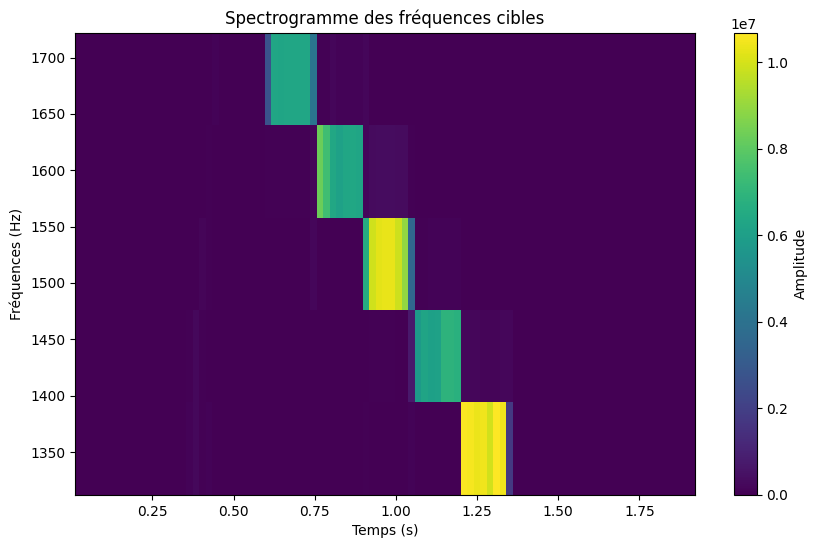

In [21]:
import numpy as np
from scipy.io.wavfile import read
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

# Charger le fichier audio
sample_rate, signal = read("alarms/hyper_chien.wav")  # Remplacez par votre propre fichier

# Si le signal est stéréo, on le convertit en mono
if len(signal.shape) > 1:
    signal = signal[:, 0]

# Calculer le spectrogramme complet
frequencies, times, Sxx = spectrogram(signal, fs=sample_rate, nperseg=1024)

# Fréquences cibles à détecter
target_frequencies = [1312, 1410, 1500, 1619, 1722]

# Trouver les indices des fréquences cibles dans le spectrogramme
indices = [np.argmin(np.abs(frequencies - f)) for f in target_frequencies]

# Extraire l'amplitude de ces fréquences au fil du temps
filtered_matrix = Sxx[indices, :]

# Affichage du spectrogramme en utilisant 'imshow' avec les fréquences sur l'axe des ordonnées
plt.figure(figsize=(10, 6))
plt.imshow(filtered_matrix, aspect='auto', origin='lower', cmap='viridis', 
           extent=[times[0], times[-1], target_frequencies[-1], target_frequencies[0]])

# Inverser l'axe des ordonnées pour avoir les basses fréquences en bas
plt.gca().invert_yaxis()

# Ajouter des labels et un titre
plt.xlabel("Temps (s)")
plt.ylabel("Fréquences (Hz)")
plt.title("Spectrogramme des fréquences cibles")

# Ajouter une barre de couleur pour représenter l'amplitude
plt.colorbar(label="Amplitude")

# Afficher le graphique
plt.show()


C:\Users\hugon\AppData\Local\Temp\ipykernel_31224\4130703816.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, signal = read(filename)


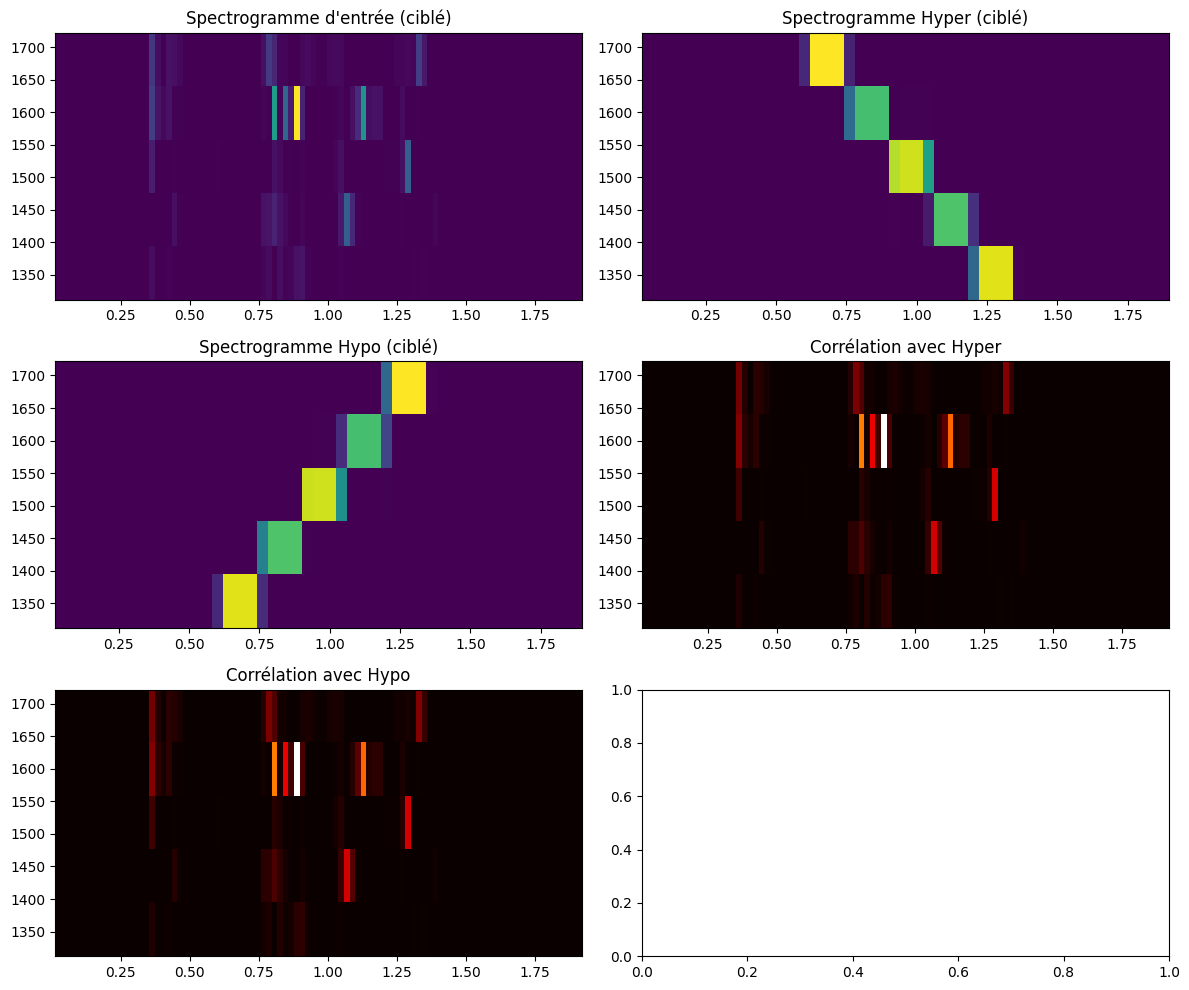

In [3]:
import numpy as np
from scipy.io.wavfile import read
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

# Fonction pour charger un fichier audio
def load_audio(filename):
    sample_rate, signal = read(filename)
    if len(signal.shape) > 1:
        signal = signal[:, 0]  # Convertir en mono si stéréo
    return sample_rate, signal

# Fonction pour calculer le spectrogramme d'un signal
def compute_spectrogram(signal, sample_rate):
    frequencies, times, Sxx = spectrogram(signal, fs=sample_rate, nperseg=1024)
    return frequencies, times, Sxx

# Fonction pour extraire les indices des fréquences cibles dans le spectrogramme
def get_target_indices(frequencies, target_frequencies):
    return [np.argmin(np.abs(frequencies - f)) for f in target_frequencies]

# Fréquences cibles à analyser
target_frequencies = [1312, 1410, 1500, 1619, 1722]

# Charger les fichiers de référence (hypo et hyper)
sample_rate_hyper, hyper_signal = load_audio("alarms/hyper.wav")
sample_rate_hypo, hypo_signal = load_audio("alarms/hypo.wav")

# Calculer les spectrogrammes des signaux de référence
frequencies_hyper, times_hyper, Sxx_hyper = compute_spectrogram(hyper_signal, sample_rate_hyper)
frequencies_hypo, times_hypo, Sxx_hypo = compute_spectrogram(hypo_signal, sample_rate_hypo)

# Charger un fichier audio d'entrée
sample_rate_input, input_signal = load_audio("alarms/hyper_chien.wav")  # Remplacer par le nom du fichier d'entrée

# Calculer le spectrogramme du fichier audio d'entrée
frequencies_input, times_input, Sxx_input = compute_spectrogram(input_signal, sample_rate_input)

# Extraire les indices des fréquences cibles
indices = get_target_indices(frequencies_hyper, target_frequencies)

# Extraire les spectrogrammes pour ces fréquences cibles uniquement
filtered_Sxx_input = Sxx_input[indices, :]
filtered_Sxx_hyper = Sxx_hyper[indices, :]
filtered_Sxx_hypo = Sxx_hypo[indices, :]

# Affichage du spectrogramme en utilisant 'imshow' avec les fréquences sur l'axe des ordonnées
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Spectrogramme d'entrée (filtré)
axes[0, 0].imshow(filtered_Sxx_input, aspect='auto', origin='lower', cmap='viridis', 
                  extent=[times_input[0], times_input[-1], target_frequencies[-1], target_frequencies[0]])
axes[0, 0].invert_yaxis()  # Inverser l'axe des ordonnées pour avoir les basses fréquences en bas
axes[0, 0].set_title("Spectrogramme d'entrée (ciblé)")

# Spectrogramme hyper (filtré)
axes[0, 1].imshow(filtered_Sxx_hyper, aspect='auto', origin='lower', cmap='viridis', 
                  extent=[times_hyper[0], times_hyper[-1], target_frequencies[-1], target_frequencies[0]])
axes[0, 1].invert_yaxis()
axes[0, 1].set_title("Spectrogramme Hyper (ciblé)")

# Spectrogramme hypo (filtré)
axes[1, 0].imshow(filtered_Sxx_hypo, aspect='auto', origin='lower', cmap='viridis', 
                  extent=[times_hypo[0], times_hypo[-1], target_frequencies[-1], target_frequencies[0]])
axes[1, 0].invert_yaxis()
axes[1, 0].set_title("Spectrogramme Hypo (ciblé)")

# Corrélation avec hyper
axes[1, 1].imshow(filtered_Sxx_input, aspect='auto', origin='lower', cmap='hot', 
                  extent=[times_input[0], times_input[-1], target_frequencies[-1], target_frequencies[0]])
axes[1, 1].invert_yaxis()
axes[1, 1].set_title("Corrélation avec Hyper")

# Corrélation avec hypo
axes[2, 0].imshow(filtered_Sxx_input, aspect='auto', origin='lower', cmap='hot', 
                  extent=[times_input[0], times_input[-1], target_frequencies[-1], target_frequencies[0]])
axes[2, 0].invert_yaxis()
axes[2, 0].set_title("Corrélation avec Hypo")

plt.tight_layout()
plt.show()



C:\Users\hugon\AppData\Local\Temp\ipykernel_31224\2046507803.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, signal = read(filename)
C:\Users\hugon\AppData\Local\Temp\ipykernel_31224\2046507803.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


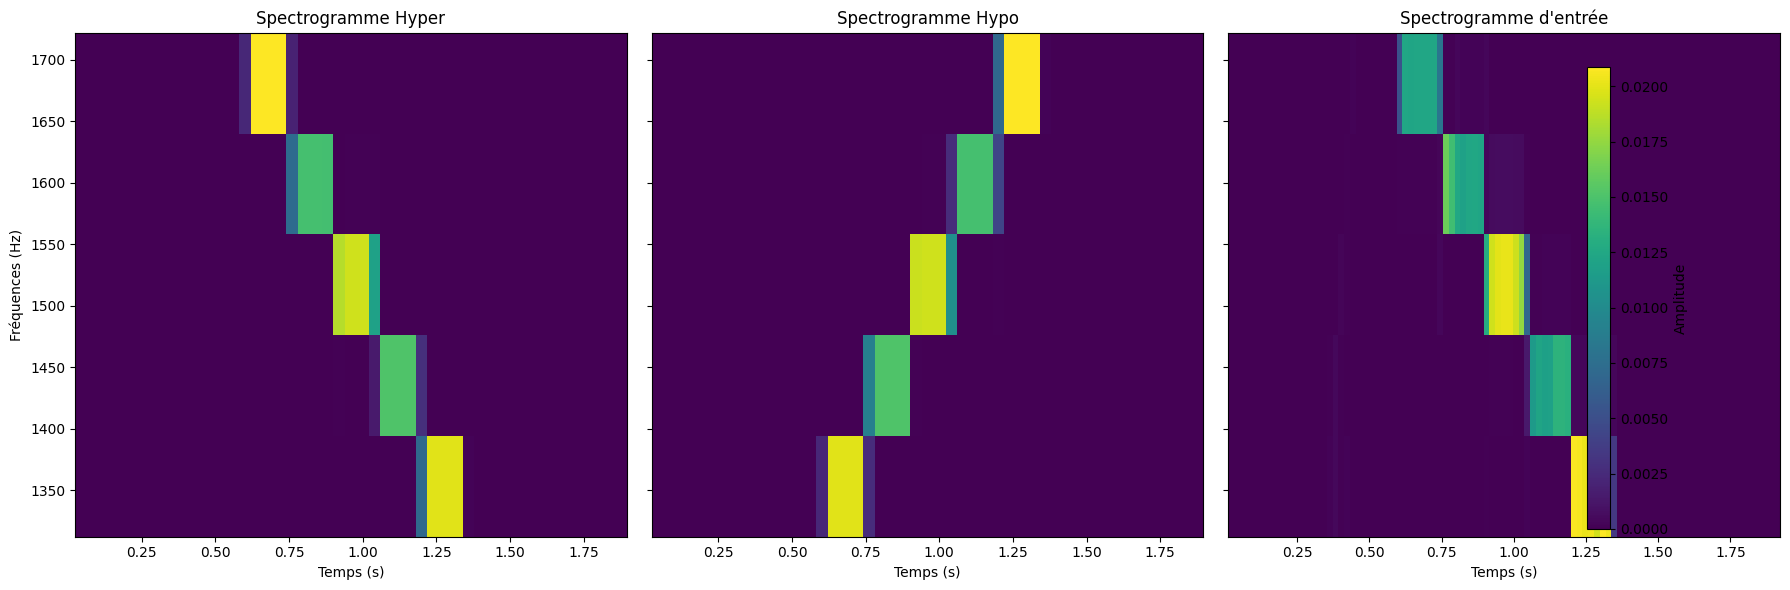

In [2]:
import numpy as np
from scipy.io.wavfile import read
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

# Fonction pour charger un fichier audio
def load_audio(filename):
    sample_rate, signal = read(filename)
    if len(signal.shape) > 1:  # Convertir en mono si stéréo
        signal = signal[:, 0]
    return sample_rate, signal

# Fonction pour calculer et filtrer le spectrogramme
def filtered_spectrogram(signal, sample_rate, target_frequencies):
    frequencies, times, Sxx = spectrogram(signal, fs=sample_rate, nperseg=1024)
    indices = [np.argmin(np.abs(frequencies - f)) for f in target_frequencies]
    filtered_matrix = Sxx[indices, :]
    return frequencies, times, filtered_matrix

# Fréquences cibles
target_frequencies = [1312, 1410, 1500, 1619, 1722]

# Charger les fichiers audio
sample_rate_hyper, hyper_signal = load_audio("alarms/hyper.wav")
sample_rate_hypo, hypo_signal = load_audio("alarms/hypo.wav")
sample_rate_input, input_signal = load_audio("alarms/hyper_chien.wav")  # Remplacez par votre fichier

# Calculer les spectrogrammes filtrés
_, times_hyper, filtered_hyper = filtered_spectrogram(hyper_signal, sample_rate_hyper, target_frequencies)
_, times_hypo, filtered_hypo = filtered_spectrogram(hypo_signal, sample_rate_hypo, target_frequencies)
_, times_input, filtered_input = filtered_spectrogram(input_signal, sample_rate_input, target_frequencies)

# Affichage des spectrogrammes côte à côte
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Spectrogramme hyper
im1 = axes[0].imshow(filtered_hyper, aspect='auto', origin='lower', cmap='viridis',
                     extent=[times_hyper[0], times_hyper[-1], target_frequencies[-1], target_frequencies[0]])
axes[0].invert_yaxis()
axes[0].set_title("Spectrogramme Hyper")
axes[0].set_xlabel("Temps (s)")
axes[0].set_ylabel("Fréquences (Hz)")

# Spectrogramme hypo
im2 = axes[1].imshow(filtered_hypo, aspect='auto', origin='lower', cmap='viridis',
                     extent=[times_hypo[0], times_hypo[-1], target_frequencies[-1], target_frequencies[0]])
axes[1].invert_yaxis()
axes[1].set_title("Spectrogramme Hypo")
axes[1].set_xlabel("Temps (s)")

# Spectrogramme d'entrée
im3 = axes[2].imshow(filtered_input, aspect='auto', origin='lower', cmap='viridis',
                     extent=[times_input[0], times_input[-1], target_frequencies[-1], target_frequencies[0]])
axes[2].invert_yaxis()
axes[2].set_title("Spectrogramme d'entrée")
axes[2].set_xlabel("Temps (s)")

# Ajouter une barre de couleur partagée pour les trois spectrogrammes
fig.colorbar(im1, ax=axes, orientation='vertical', label="Amplitude", fraction=0.02, pad=0.04)

# Ajuster l'espacement
plt.tight_layout()
plt.show()


Corrélation avec Hyper: 1.00
Corrélation avec Hypo: 0.24
Résultat: Hyper


C:\Users\hugon\AppData\Local\Temp\ipykernel_31224\659796947.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


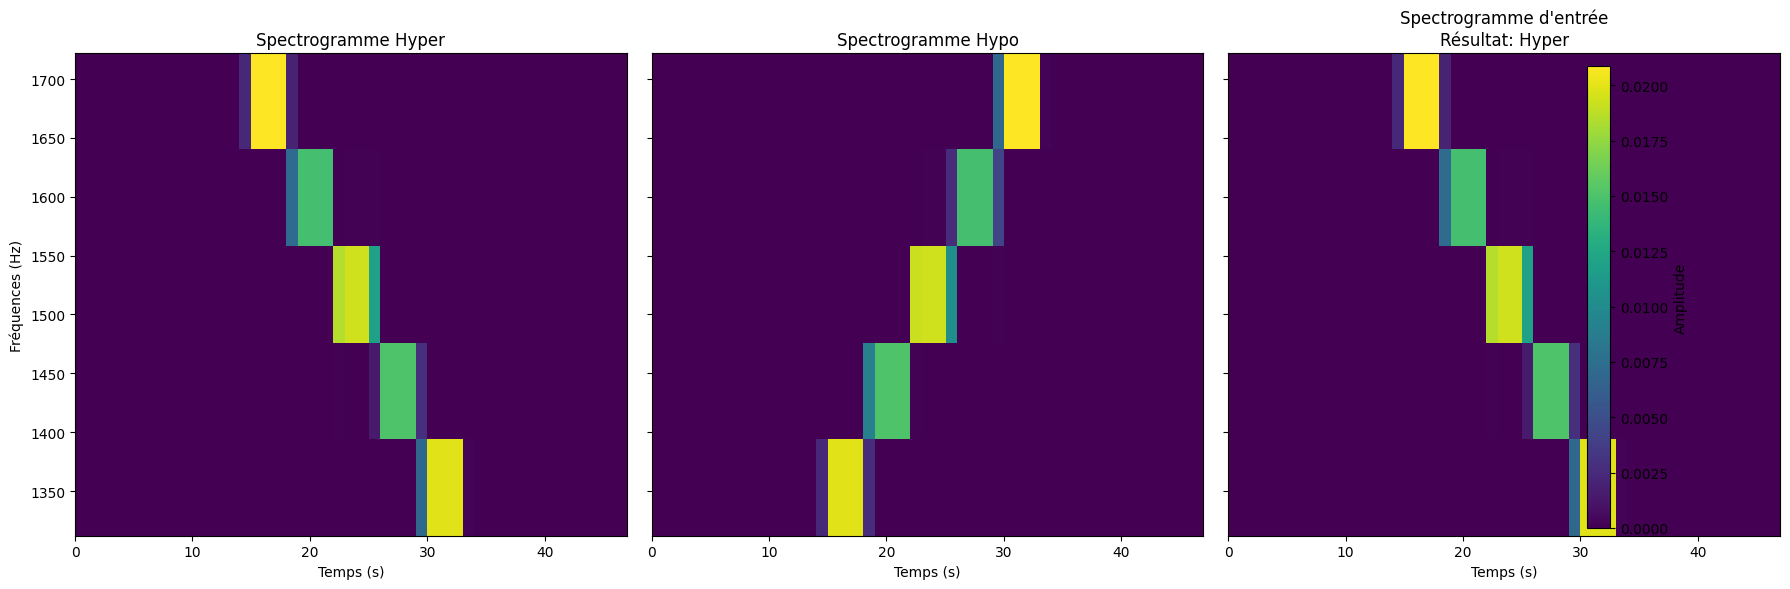

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.30291742e-03 2.08728369e-02
  2.08728798e-02 2.08728891e-02 2.01947498e-03 1.68751637e-06
  1.68768520e-06 1.44070600e-06 3.61181810e-05 1.31681315e-06
  1.31692707e-06 6.14783949e-06 5.88860694e-08 5.88367186e-08
  5.88630584e-08 2.79816760e-07 8.11128720e-10 8.16245571e-10
  8.06268663e-10 2.17073489e-06 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 7.42068587e-05 3.80919628e-05
  3.80938291e-05 3.809

In [ ]:
import numpy as np
from scipy.io.wavfile import read
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

# Fonction pour charger un fichier audio
def load_audio(filename):
    sample_rate, signal = read(filename)
    if len(signal.shape) > 1:  # Convertir en mono si stéréo
        signal = signal[:, 0]
    return sample_rate, signal

# Fonction pour calculer et filtrer le spectrogramme
def filtered_spectrogram(signal, sample_rate, target_frequencies):
    frequencies, times, Sxx = spectrogram(signal, fs=sample_rate, nperseg=1024)
    indices = [np.argmin(np.abs(frequencies - f)) for f in target_frequencies]
    filtered_matrix = Sxx[indices, :]
    return times, filtered_matrix

# Fonction pour ajuster les dimensions des matrices
def match_dimensions(matrix1, matrix2):
    min_columns = min(matrix1.shape[1], matrix2.shape[1])
    matrix1 = matrix1[:, :min_columns]
    matrix2 = matrix2[:, :min_columns]
    return matrix1, matrix2

# Fonction pour calculer la corrélation absolue
def compute_absolute_correlation(matrix1, matrix2):
    matrix1, matrix2 = match_dimensions(matrix1, matrix2)  # Ajuster les dimensions
    norm1 = np.linalg.norm(matrix1)
    norm2 = np.linalg.norm(matrix2)
    correlation = np.abs(np.sum(matrix1 * matrix2) / (norm1 * norm2))  # Corrélation absolue
    return correlation

# Fréquences cibles
target_frequencies = [1312, 1410, 1500, 1619, 1722]

# Charger les fichiers audio
sample_rate_hyper, hyper_signal = load_audio("alarms/hyper.wav")
sample_rate_hypo, hypo_signal = load_audio("alarms/hypo.wav")
sample_rate_input, input_signal = load_audio("alarms/hypo.wav")  # Remplacez par votre fichier d'entrée

# Calculer les spectrogrammes filtrés
times_hyper, filtered_hyper = filtered_spectrogram(hyper_signal, sample_rate_hyper, target_frequencies)
times_hypo, filtered_hypo = filtered_spectrogram(hypo_signal, sample_rate_hypo, target_frequencies)
times_input, filtered_input = filtered_spectrogram(input_signal, sample_rate_input, target_frequencies)

# Calculer les corrélations entre le son d'entrée et les sons de référence
correlation_hyper = compute_absolute_correlation(filtered_input, filtered_hyper)
correlation_hypo = compute_absolute_correlation(filtered_input, filtered_hypo)

# Déterminer le résultat basé sur la corrélation la plus élevée
if correlation_hyper > correlation_hypo:
    result = "Hyper"
elif correlation_hypo > correlation_hyper:
    result = "Hypo"
else:
    result = "Inconnu"

# Affichage des résultats
print(f"Corrélation avec Hyper: {correlation_hyper:.2f}")
print(f"Corrélation avec Hypo: {correlation_hypo:.2f}")
print(f"Résultat: {result}")

# Affichage des spectrogrammes
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Spectrogramme Hyper
im1 = axes[0].imshow(filtered_hyper, aspect='auto', origin='lower', cmap='viridis',
                     extent=[0, filtered_hyper.shape[1], target_frequencies[-1], target_frequencies[0]])
axes[0].invert_yaxis()
axes[0].set_title("Spectrogramme Hyper")
axes[0].set_xlabel("Temps (s)")
axes[0].set_ylabel("Fréquences (Hz)")

# Spectrogramme Hypo
im2 = axes[1].imshow(filtered_hypo, aspect='auto', origin='lower', cmap='viridis',
                     extent=[0, filtered_hypo.shape[1], target_frequencies[-1], target_frequencies[0]])
axes[1].invert_yaxis()
axes[1].set_title("Spectrogramme Hypo")
axes[1].set_xlabel("Temps (s)")

# Spectrogramme d'entrée
im3 = axes[2].imshow(filtered_input, aspect='auto', origin='lower', cmap='viridis',
                     extent=[0, filtered_input.shape[1], target_frequencies[-1], target_frequencies[0]])
axes[2].invert_yaxis()
axes[2].set_title(f"Spectrogramme d'entrée\nRésultat: {result}")
axes[2].set_xlabel("Temps (s)")

# Ajouter une barre de couleur partagée pour les trois spectrogrammes
fig.colorbar(im1, ax=axes, orientation='vertical', label="Amplitude", fraction=0.02, pad=0.04)

# Ajuster l'espacement
plt.tight_layout()
plt.show()
print(filtered_input)
